## Import packages

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
%pwd

'C:\\Users\\Admin\\Documents\\objdet_project'

This image is  <class 'numpy.ndarray'>  with dimensions:  (171, 294, 3)


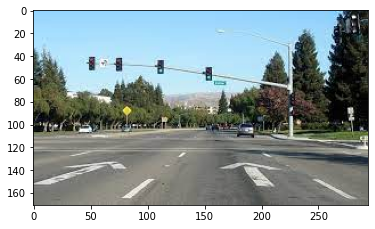

In [36]:
# Read an image
from pathlib import Path

img_path = Path() / "images" / "road2.jfif"
image = mpimg.imread(img_path)

# print results
print('This image is ', type(image), ' with dimensions: ', image.shape)
plt.imshow(image)

## ideas for lane detection pipeline

Some OpenCV functions:
1. `cv.inRange()` for color selection
2. `cv.fillPoly()` for ROI selection (triangular or rectangular)
3. `cv.line()` draw lines
4. `cv.addweighted()` for image superimpose / overlay
5. `cv.cvtColor()` convert colorspaces
6. `cv.imwrite()` save image
7. `cv.bitwise_and()` apply mask to an image

In [39]:
# Let set up some helper functions
import math

# canny parameters

# Gaussian blur parameters

# ROI selection
def region_of_interest(img, vertices):
    """
    Applies image mask
    Arguments:
    vertices: list of coordinates for cv.fillPoly()
    Return:
    Image masked by the region enclosed by vertices
    """
    mask = np.zeros_like(img)
    
    # defining a 3 channel or 1 channel color to fill the mask with
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        mask_color = (255,) * channel_count
    else:
        mask_color = 255
        
    # fill the pixel inside the polygon defined by vertices
    cv.fillPoly(mask, pts=[vertices], color=mask_color)
    
    masked_image = cv.bitwise_and(img, mask)
    return masked_image

# draw lines (lanes)
def draw_lines(img, lines, color = (255, 0, 0), thickness=2):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    # reserve the original image
    img_copy = np.copy(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # sketch the line on black pad
                cv.line(line_img, (x1, y1), (x2, y2), color, thickness)
                
    img_copy = cv.addWeighted(img_copy, 0.8, line_img, 1.0, 0.0)
    return img_copy

def pipeline(image):
    """
    Image processing pipeline which will output an image with the lane lines annotated.
    Might consider to add in canny hysterisis thresholding and Gaussian blur kernel size.
    """
    height = image.shape[0]
    width = image.shape[1]
    # define the vertices (triangle)
    roi_vertices = np.array([
        (0, height),
        (int(width/2), int(height/2)),
        (width, height)
    ])
    
    # image_blur = cv.GaussianBlur(image, (5, 5), 0)
    # convert grayscale
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    # Gaussian blur?
    # gray_image = cv.GaussianBlur(gray_image, (5, 5), 0)
    # Canny edge detector
    edges = cv.Canny(gray_image, 50, 180)
    
    # Cropped image
    cropped_image = region_of_interest(
        edges, roi_vertices
    )
    # detect line
    lines = cv.HoughLinesP(
        cropped_image, 
        rho=6,
        theta=np.pi/60,
        threshold=150,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
    # line fitting using the points found from Hough Line transform
    # to get the 2 pair of coordinates that join to form 2 lanes 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            # Omit slope less than |0.5|
#             if math.fabs(slope) < 0.5:
#                 continue
#             else:
            if slope <=0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
                    
    min_y = int(image.shape[0]*0.6)
    max_y = int(image.shape[0])
    
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
    
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
    
    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
        deg=1
    ))
    
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    
    line_image = draw_lines(image, [[[left_x_start, max_y, left_x_end, min_y],
                                   [right_x_start, max_y, right_x_end, min_y]]])
    
    return line_image

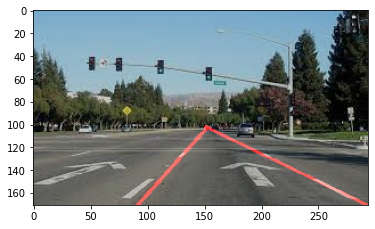

In [40]:
res = pipeline(image)
plt.imshow(res)

In [9]:
mask = np.zeros_like(image)
    
# defining a 3 channel or 1 channel color to fill the mask with
if len(image.shape) > 2:
    channel_count = image.shape[2]
    mask_color = (255,) * channel_count
else:
    mask_color = 255

# fill the pixel inside the polygon defined by vertices
height = image.shape[0]
width = image.shape[1]
roi_vertices = np.array([
    (0, height),
    (int(width/2), int(height/2)),
    (width, height)
])
cv.fillPoly(mask, pts = [roi_vertices], color = mask_color)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]